# Проект: классификация

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import iqr
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
import optuna 

%matplotlib inline
plt.style.use('seaborn')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [66]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).


Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [68]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
missing_values = df.isnull().sum()
missing_values

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [69]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [70]:
# получение уникальных значений в столбце 'job'
unique_jobs = df['job'].unique()
missing_words = set()
# поиск уникальных слов-кодов для пропусков в столбце 'job'
for job in unique_jobs:
    if job == 'unknown':
        missing_words.add(job)
print("Уникальные слова-коды для пропусков в столбце 'job':")
for word in missing_words:
    print(word)

Уникальные слова-коды для пропусков в столбце 'job':
unknown


### Задание 3

In [71]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace(' ', '', regex=True)
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.split('$').str[0]
df['balance'] = df['balance'].astype(float)

print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [72]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_balance = df['balance'].median()
# замена пропусков на медианное значение
df['balance'].fillna(median_balance, inplace=True)
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [73]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# замена пропусков в признаке 'job'
job_mode = df['job'].mode()[0]
df['job'] = df['job'].replace('unknown', job_mode)

# замена пропусков в признаке 'education'
education_mode = df['education'].mode()[0]
df['education'] = df['education'].replace('unknown', education_mode)

# вычисление среднего баланса для клиентов с самой популярной работой и самым популярным уровнем образования
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

mean_balance = df[(df['job'] == popular_job) & (df['education'] == popular_education)]['balance'].mean()
print(round(mean_balance, 3))

1598.883


### Задание 6

In [74]:
# удалите все выбросы для признака balance
quantile_1, quantile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
iqr = quantile_3 - quantile_1 
# вычисляем верхнюю и нижнюю границы Тьюки
lower_bound = quantile_1 - iqr * 1.5
upper_bound = quantile_3 + iqr * 1.5
print('Нижняя граница выбросов:', int(lower_bound))
print('Верхняя граница выбросов:', int(upper_bound))

outliers = df[(df['balance'] <= lower_bound) | (df['balance'] >= upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)].reset_index().drop('index', axis=1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df .shape[0]}')

Нижняя граница выбросов: -2241
Верхняя граница выбросов: 4063
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

Количество клиентов, открывших депозит: 4681
Количество клиентов, неоткрывших депозит: 5424


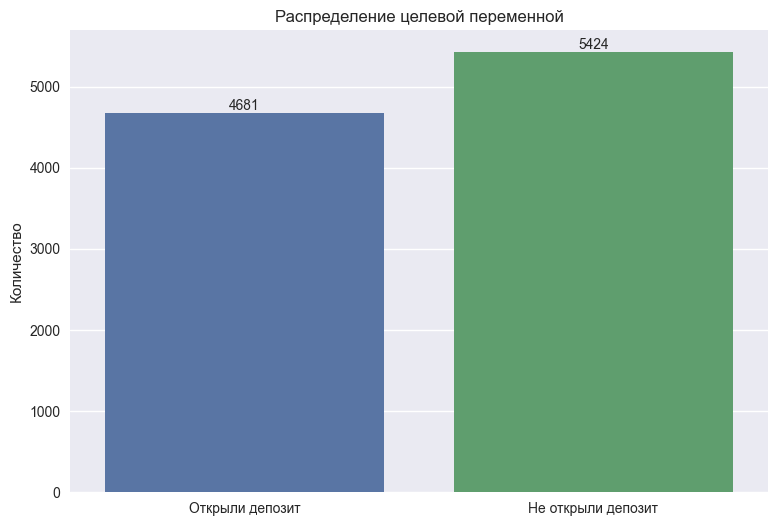

In [75]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
deposit_counts = df['deposit'].value_counts()
opened_deposit = deposit_counts['yes']
not_opened_deposit = deposit_counts['no']
print('Количество клиентов, открывших депозит:', opened_deposit)
print('Количество клиентов, неоткрывших депозит:', not_opened_deposit)

labels = ['Открыли депозит', 'Не открыли депозит']
values = [opened_deposit, not_opened_deposit]

fig, ax = plt.subplots(figsize=(9, 6))
barplot = sns.barplot(x=labels, y=values, ax=ax)
barplot.set_title('Распределение целевой переменной')
barplot.bar_label(barplot.containers[0])
barplot.set(ylabel='Количество')
plt.show()

В данном случае можно сказать, что классы относительно сбалансированы. Количество клиентов, открывших депозит 4681, и количество клиентов, не открывших депозит 5424, отличаются не существенно. Разница между классами составляет всего около 10%. Это говорит о том, что данные достаточно сбалансированы с точки зрения целевой переменной "открытие депозита".

### Задания 2 и 3

In [76]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [77]:
df['deposit'] = df['deposit'].apply(lambda x: int(1) if x == 'yes' else int(0))

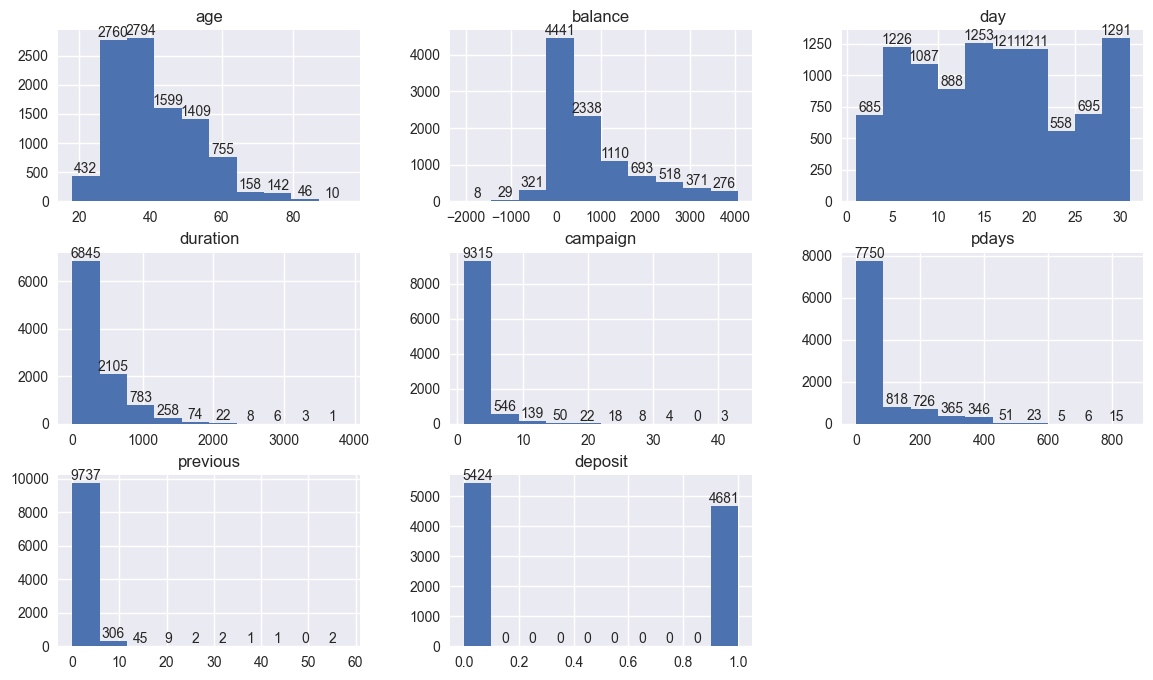

In [78]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
num_features = df.hist(figsize=(14, 8))

for ax in num_features.flatten():
    for rect in ax.patches:
        ax.annotate(f"{rect.get_height():.0f}", (rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    ha='center', va='bottom')
plt.show()

In [79]:
# максимальный возраст клиента
max_age = df['age'].max()
print('Максимальный возраст клиента:', max_age)

Максимальный возраст клиента: 95


In [80]:
# минимальная продолжиетлность разговора
min_duration = df['duration'].min()
print('Минимальная продолжительность разговора с клиентом:', min_duration, 'секунд')

Минимальная продолжительность разговора с клиентом: 2 секунд


### 1. Зависимость между целевым признаком 'deposit' и и количественной переменной 'age'

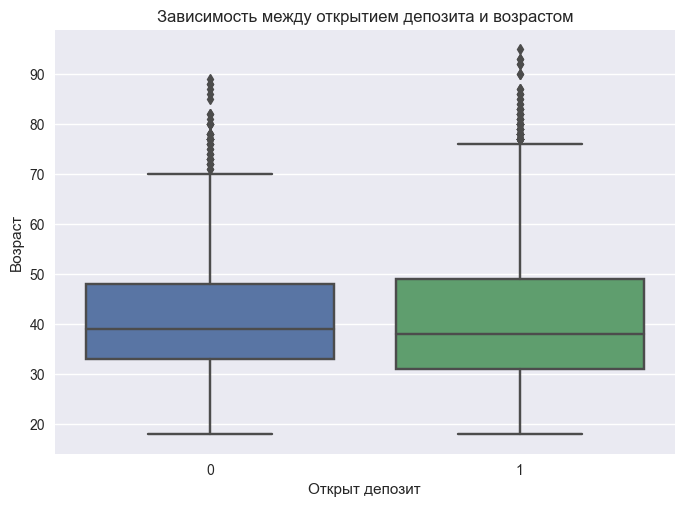

In [81]:
sns.boxplot(data=df, x='deposit', y='age')
plt.xlabel('Открыт депозит')
plt.ylabel('Возраст')
plt.title('Зависимость между открытием депозита и возрастом')
plt.show()

На основе графика можно сделать следующие наблюдения: с возраста 18 лет количество клиентов, открывающих депозиты в банке, начинает резко возрастать и достигает пика в возрасте от 31 до 33 лет. После этого пика количество клиентов, открывающих депозиты, постепенно уменьшается после достижения возраста 36 лет. Это наблюдение может быть полезным для банка при определении целевой аудитории и разработке маркетинговых стратегий, нацеленных на привлечение клиентов для открытия депозитов.

### 2. Зависимость между целевым признаком 'deposit' и и количественной переменной 'balance'

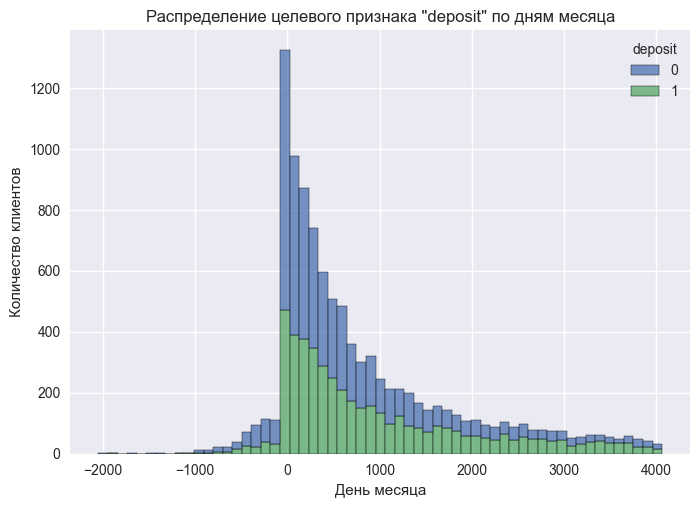

In [82]:
sns.histplot(data=df, x='balance', hue='deposit', multiple='stack')
plt.xlabel('День месяца')
plt.ylabel('Количество клиентов')
plt.title('Распределение целевого признака "deposit" по дням месяца')
plt.show()

In [83]:
print(df['balance'].min())
print(df['balance'].max())

-2049.0
4063.0


Из графика можно сделать следующие наблюдения: распределение баланса клиентов банка имеет выраженную асимметрию вправо, что означает наличие небольшой группы клиентов с очень высоким балансом на счете. Однако, при анализе взаимосвязи между балансом и целевым признаком "deposit" на графике видно, что большинство клиентов с низким балансом не открывают депозиты, в то время как клиенты с более высоким балансом имеют более равномерное распределение между открывшими и не открывшими депозиты.

### 3. Зависимость между целевым признаком 'deposit' и и количественной переменной 'day'

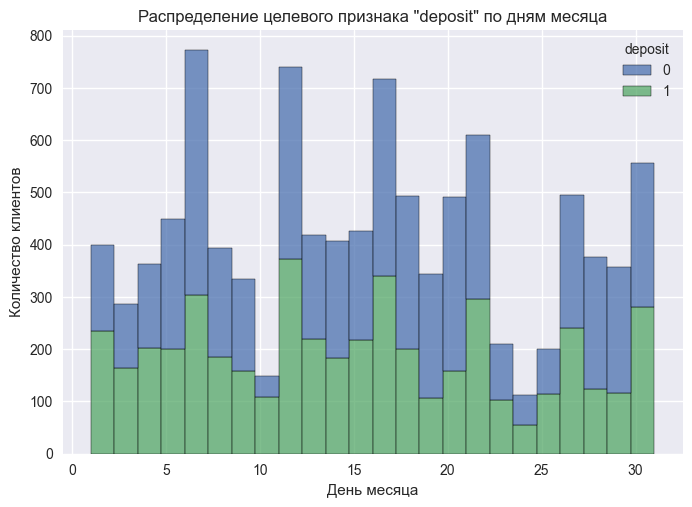

In [84]:
sns.histplot(data=df, x='day', hue='deposit', multiple='stack')
plt.xlabel('День месяца')
plt.ylabel('Количество клиентов')
plt.title('Распределение целевого признака "deposit" по дням месяца')
plt.show()

На графике видны несколько характерных пиков и минимумов в распределении клиентов по дням месяца. Локальные пики наблюдаются в первый и последний день месяца, в начале месяца (с 6 по 7 день), в середине месяца (с 11 по 17 день). Таким образом, пики могут отражать повышенный интерес клиентов к открытию депозита в дни получения доходов, а минимумы могут быть связаны с периодами, когда клиенты имеют меньше свободных средств для открытия депозита.

Анализ этих пиков и минимумов может помочь банку лучше понять предпочтения клиентов и оптимизировать стратегию проведения маркетинговых кампаний и предложений о депозите в зависимости от дня месяца.

### 4. Зависимость между целевым признаком 'deposit' и и количественной переменной 'duration'

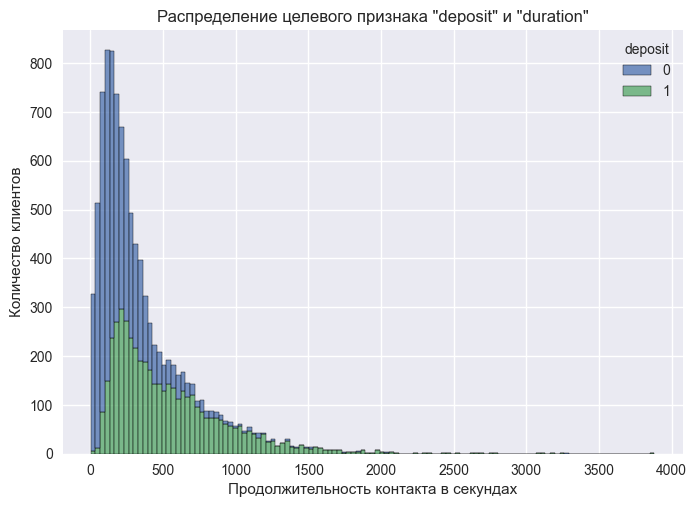

In [85]:
sns.histplot(data=df, x='duration', hue='deposit', multiple='stack')
plt.xlabel('Продолжительность контакта в секундах')
plt.ylabel('Количество клиентов')
plt.title('Распределение целевого признака "deposit" и "duration"')
plt.show()

Как видно из графика, увеличение продолжительности контакта с клиентами до примерно 300 секунд приводит к увеличению количества открытых депозитов. Однако после этого значения график становится менее плавным и наблюдается большой разброс количества открытых депозитов при определенной продолжительности контакта. Это указывает на то, что существуют и другие факторы, которые влияют на целевой признак, и/или влияние продолжительности контакта на него не такое сильное.

### 5. Зависимость между целевым признаком 'deposit' и и количественной переменной  'campaign'

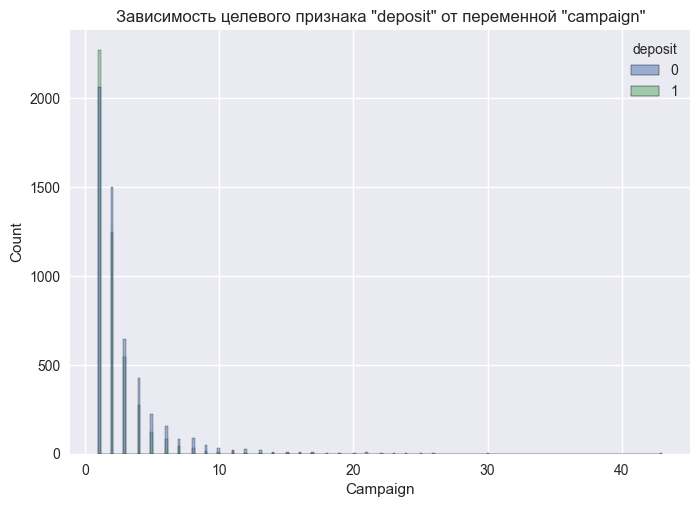

In [86]:
sns.histplot(data=df, x='campaign', hue='deposit')
plt.xlabel('Campaign')
plt.ylabel('Count')
plt.title('Зависимость целевого признака "deposit" от переменной "campaign"')
plt.show()

Таким образом, можно сделать вывод, что количество контактов в рамках кампании имеет влияние на целевой признак "deposit". Оптимальным числом контактов, при котором вероятность открытия депозита максимальна, является 1-3. Дальнейшее увеличение числа контактов может иметь ограниченную эффективность и приводить к снижению успеха кампании.

### Задания 4 и 5

In [87]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


### 1. Распределение количества контактов по месяцам

Количество месяцев, в которых проводилась маркетинговая кампания: 12


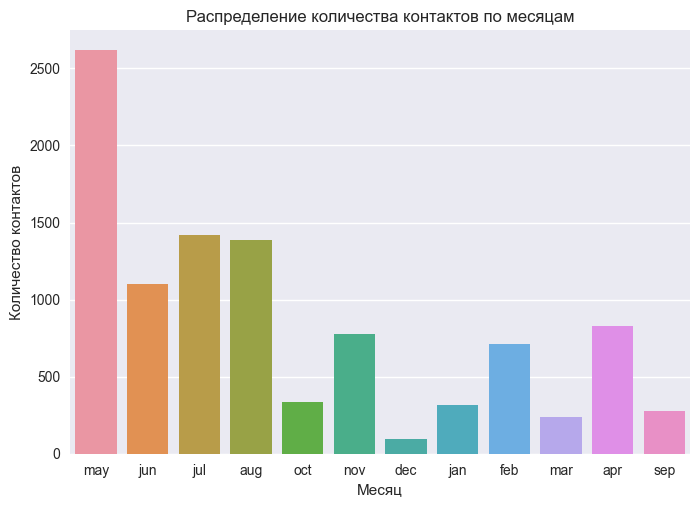

In [88]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
num_of_months = df['month'].nunique()
print('Количество месяцев, в которых проводилась маркетинговая кампания:', num_of_months)

sns.countplot(data=df, x='month')
plt.xlabel('Месяц')
plt.ylabel('Количество контактов')
plt.title('Распределение количества контактов по месяцам')
plt.show()

Анализируя распределение количества контактов с клиентами по месяцам, можно отметить, что пиковое значение приходится на месяц май, затем идет сильный спад, июля и августа также имеет относительно высокие показатели, а вот декабрь - самый минимум. Это может указывать на то, что банк активно проводит маркетинговые кампании и усиливает свои контакты с клиентами в эти периоды. Однако, после августа количество контактов снижается, что может быть связано с окончанием сезона отпусков или изменением стратегии маркетинговых действий банка. Декабрь - месяц праздников, когда люди меньше всего заинтересованы в банковских услугах.

### 2. Количество сфер занятости среди клиентов банка:

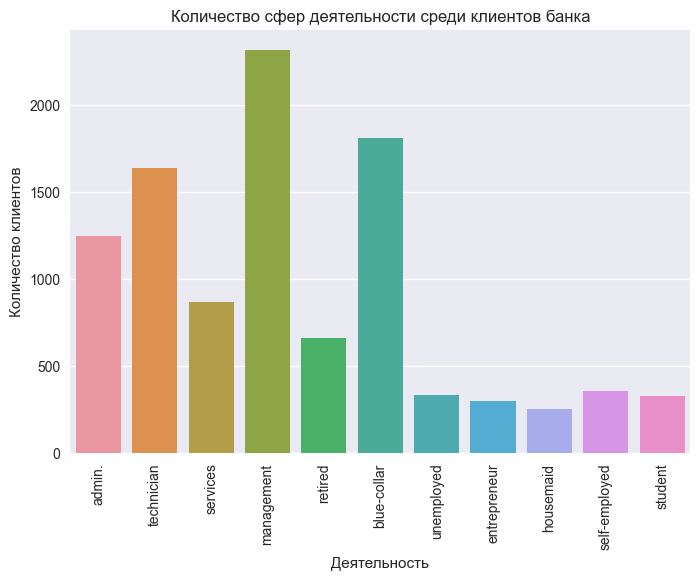

In [89]:
sns.countplot(data=df, x='job')
plt.xlabel('Деятельность')
plt.ylabel('Количество клиентов')
plt.title('Количество сфер деятельности среди клиентов банка')
plt.xticks(rotation=90) 
plt.show()

### 3. Семейное положени "marital"

Наиболее часто встречающееся семейное положение: married


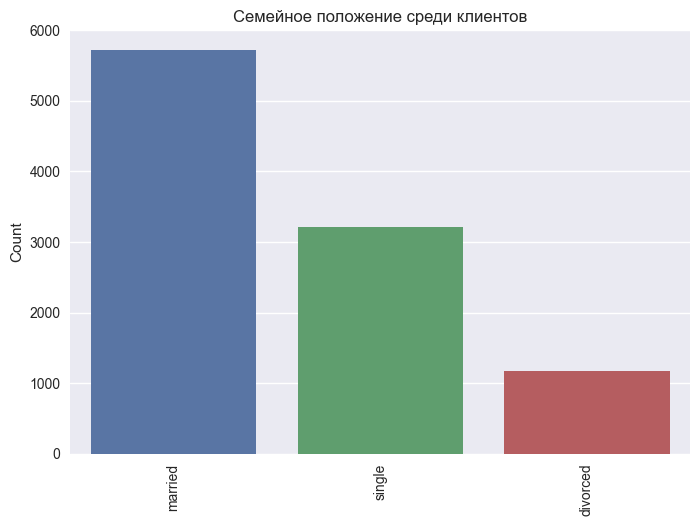

In [90]:
most_common_marital = df['marital'].value_counts().idxmax()
print('Наиболее часто встречающееся семейное положение:', most_common_marital)

sns.countplot(data=df, x='marital')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Семейное положение среди клиентов')
plt.xticks(rotation=90)  
plt.show()

 Большинство клиентов имеют статус замужем/женат, а наименьшее количество клиентов разведены. Такая информация может быть полезной для банка при планировании маркетинговых кампаний и адаптации предложений, учитывая предпочтения и потребности различных групп клиентов.

### 4. Уровень образования "education"

<bound method Series.idxmax of secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64>


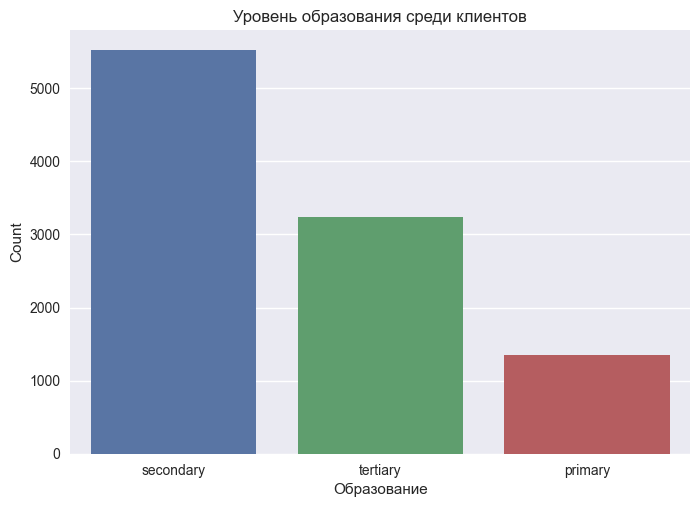

In [91]:
most_common_education = df['education'].value_counts().idxmax
print(most_common_education)

sns.countplot(data=df, x='education')
plt.xlabel('Образование')
plt.ylabel('Count')
plt.title('Уровень образования среди клиентов')
plt.show()

Исходя из анализа описательной статистики для уровня образования (education) среди клиентов банка, можно сделать вывод, что большинство клиентов имеют среднее образование, на втором месте находятся клиенты с высшим образованием, а на третьем месте — клиенты с начальным образованием. Это может указывать на то, что банку следует уделить особое внимание и разработать целевые маркетинговые стратегии для этих групп клиентов, учитывая их особенности и потребности.

### 5. Наличие кредита на жилье среди клиентов "housing"

Наличие кредита на жилье:
no     5243
yes    4862
Name: housing, dtype: int64


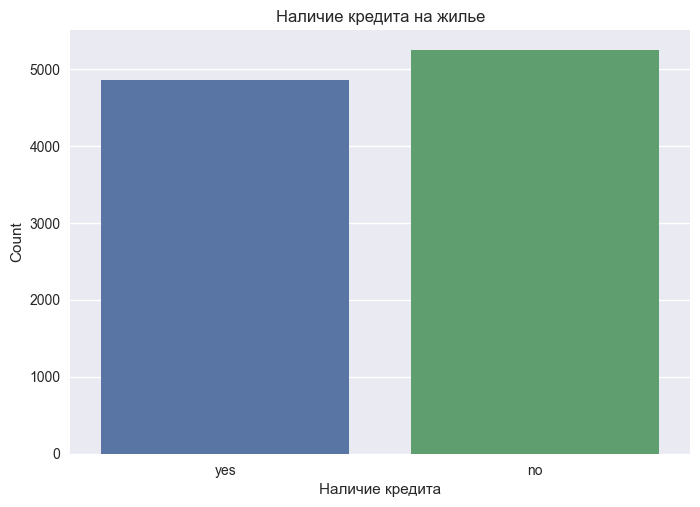

In [92]:
housing_counts = df['housing'].value_counts()
print('Наличие кредита на жилье:')
print(housing_counts)

sns.countplot(data=df, x='housing')
plt.xlabel('Наличие кредита')
plt.ylabel('Count')
plt.title('Наличие кредита на жилье')
plt.show()

Исходя из данных о наличии кредита на жилье среди клиентов банка, можно сделать вывод, что примерно половина клиентов (около 5243) не имеет кредита на жилье, в то время как другая половина (около 4862) имеет кредит на жилье. Это указывает на то, что кредит на жилье является распространенным финансовым инструментом среди клиентов банка. Данный вывод может быть полезным для банка при разработке и анализе кредитных продуктов и стратегий маркетинга, связанных с жилищным кредитованием.

### Задание 6

In [93]:
# узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   0           562
          1           547
other     1           265
          0           216
success   1           861
          0            84
unknown   0          4562
          1          3008
Name: deposit, dtype: int64

У клиентов, у которых в предыдущей маркетинговой кампании статус "succes", в текущей кампании наблюдается больше успешных результатов, чем неудачных.

### Задание 7

In [94]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# общее количество контактов и количество неудач для каждого месяца
month_counts = df['month'].value_counts()
failure_counts = df[df['deposit'] == 0]['month'].value_counts()
failure_percentages = (failure_counts / month_counts) * 100
max_failure_month = failure_percentages.idxmax()
print('Месяц с самым большим процентом неудач в текущей маркетинговой кампании:', max_failure_month)

Месяц с самым большим процентом неудач в текущей маркетинговой кампании: may


### Задание 8

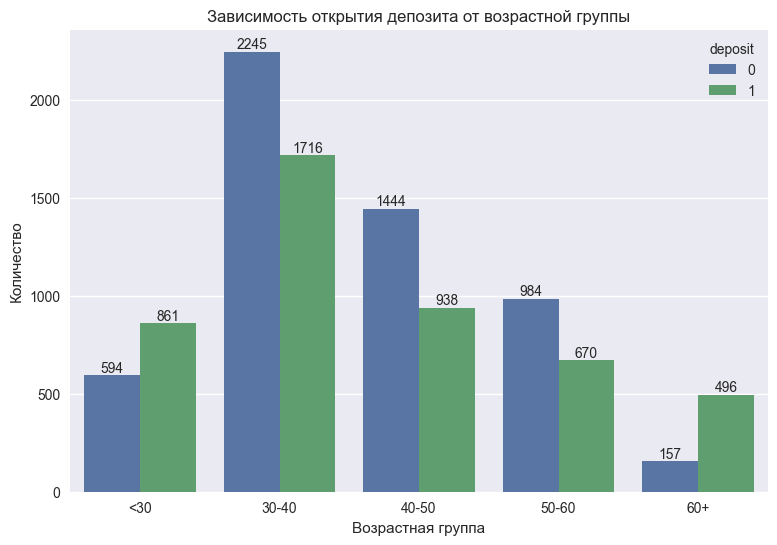

In [95]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# определение границ возрастных категорий
age_bins = [0, 30, 40, 50, 60, float('inf')]
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']

# новая переменная с индикатором возрастной категории
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

fig, ax = plt.subplots(figsize=(9, 6))
barplot = sns.countplot(data=df, x='age_group', hue='deposit')
barplot.set_title('Зависимость открытия депозита от возрастной группы')
barplot.bar_label(barplot.containers[0])
barplot.bar_label(barplot.containers[1])
barplot.set(ylabel='Количество') 
barplot.set(xlabel='Возрастная группа')
plt.show()


### Задания 9 и 10

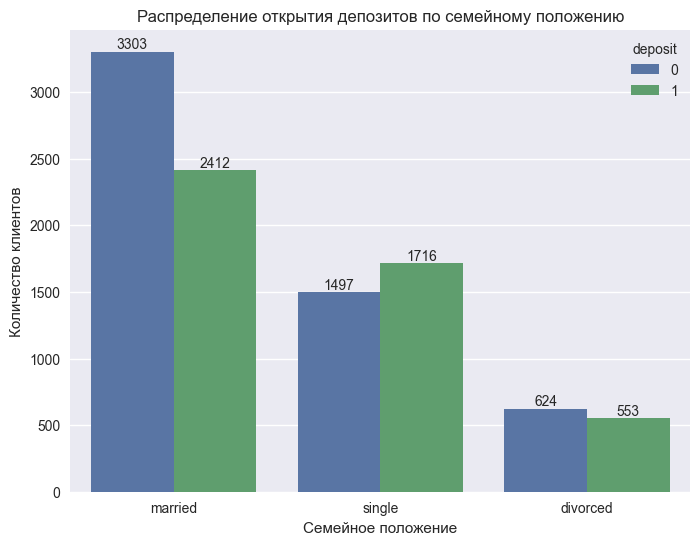

In [96]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, ax = plt.subplots(figsize=(8, 6))

barplot = sns.countplot(data=df, x='marital', hue='deposit', ax=ax)
ax.set_xlabel('Семейное положение')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение открытия депозитов по семейному положению')

for container in barplot.containers:
    ax.bar_label(container)

plt.show()

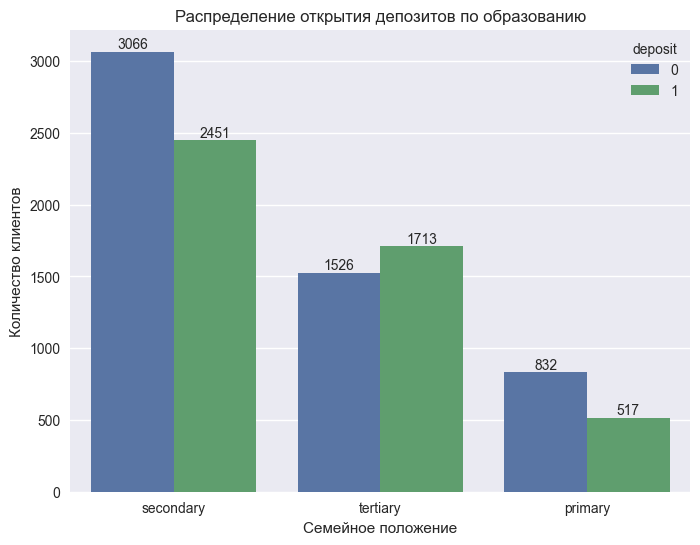

In [97]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, ax = plt.subplots(figsize=(8, 6))

barplot = sns.countplot(data=df, x='education', hue='deposit', ax=ax)
ax.set_xlabel('Семейное положение')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение открытия депозитов по образованию')

for container in barplot.containers:
    ax.bar_label(container)

plt.show()

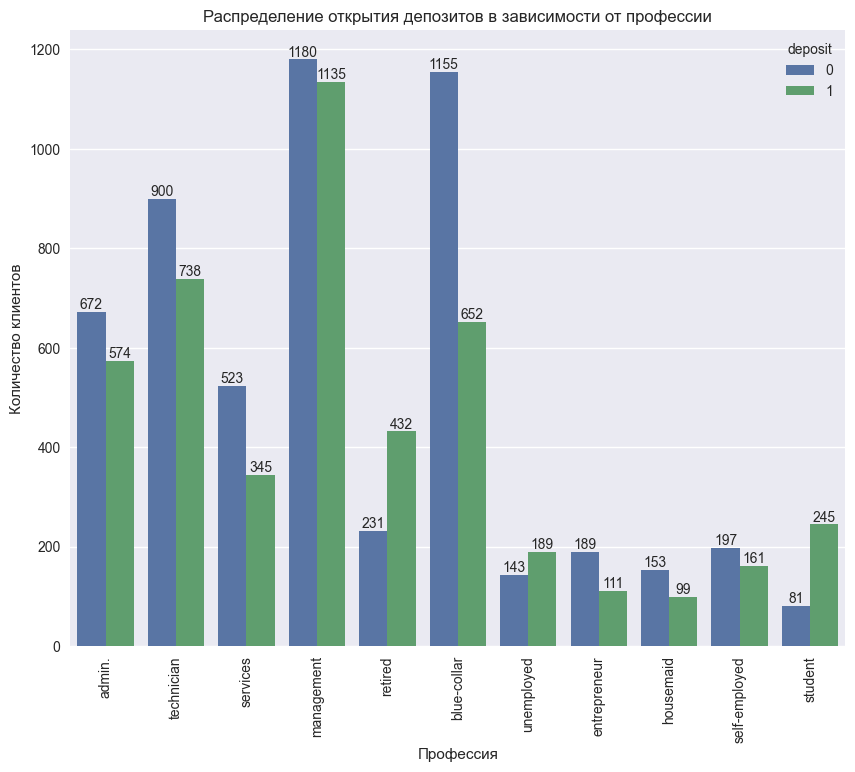

In [98]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(10, 8))

barplot = sns.countplot(data=df, x='job', hue='deposit', ax=ax)
ax.set_xlabel('Профессия')
ax.set_ylabel('Количество клиентов')
ax.set_title('Распределение открытия депозитов в зависимости от профессии')
plt.xticks(rotation=90) 

for container in barplot.containers:
    ax.bar_label(container)

plt.show()

### Задание 11

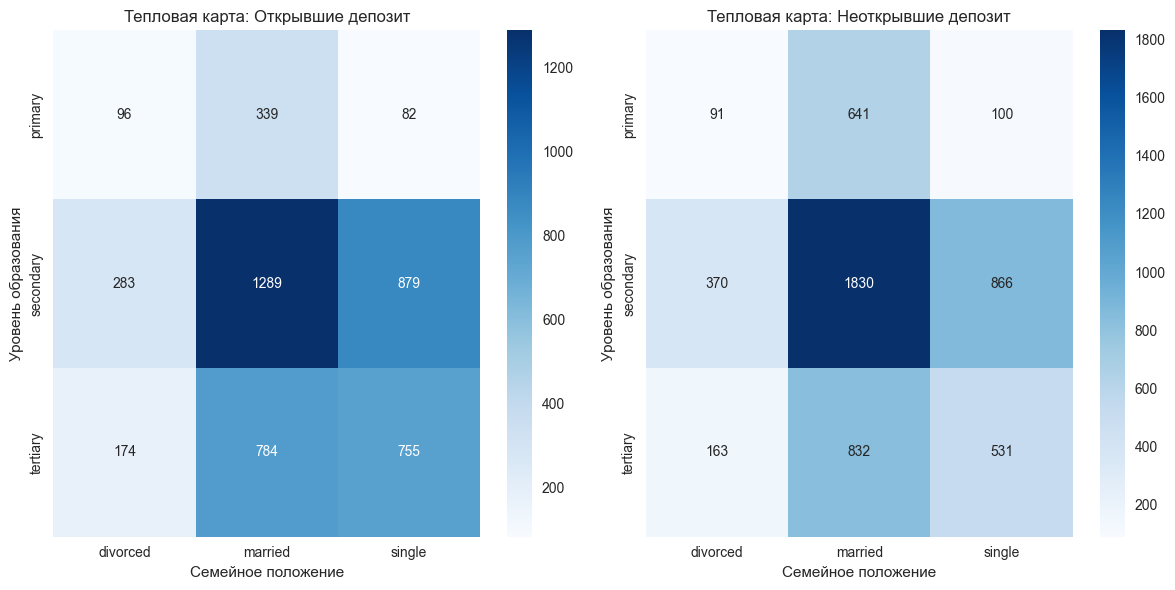

In [99]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
opened_deposit_pivot = df[df['deposit'] == 1].pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)
not_opened_deposit_pivot = df[df['deposit'] == 0].pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(opened_deposit_pivot, annot=True, cmap='Blues', fmt='d', ax=axes[0])
axes[0].set_title('Тепловая карта: Открывшие депозит')
axes[0].set_xlabel('Семейное положение')
axes[0].set_ylabel('Уровень образования')

sns.heatmap(not_opened_deposit_pivot, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_title('Тепловая карта: Неоткрывшие депозит')
axes[1].set_xlabel('Семейное положение')
axes[1].set_ylabel('Уровень образования')

plt.tight_layout()
plt.show()



## Часть 3: преобразование данных

### Задание 1

In [100]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()
df['education_encoded'] = label_encoder.fit_transform(df['education'])
print(df[['education', 'education_encoded']].head())

   education  education_encoded
0  secondary                  1
1  secondary                  1
2  secondary                  1
3  secondary                  1
4   tertiary                  2


In [101]:
# преобразуйте признак возраста
label_encoder = LabelEncoder()
df['age_encoded'] = label_encoder.fit_transform(df['age_group'])
print(df[['age_group', 'age_encoded']].head())

  age_group  age_encoded
0     50-60            2
1     50-60            2
2     40-50            1
3     50-60            2
4     50-60            2


### Задания 2 и 3

In [102]:
# преобразуйте бинарные переменные в представление из нулей и единиц
standard_deviation = df['deposit'].std()
rounded_std = round(standard_deviation, 3)
print('Стандартное отклонение целевой переменной deposit:', rounded_std)

Стандартное отклонение целевой переменной deposit: 0.499


In [103]:
# Применение преобразования к бинарным переменным
binary_variables = ['default', 'housing', 'loan']

for var in binary_variables:
    df[var] = df[var].apply(lambda x: 1 if x == 'yes' else 0)

std_devs = df[binary_variables].std().round(3)
print("Стандартное отклонение для переменной 'default':", std_devs['default'])
print("Стандартное отклонение для переменной 'housing':", std_devs['housing'])
print("Стандартное отклонение для переменной 'loan':", std_devs['loan'])


Стандартное отклонение для переменной 'default': 0.127
Стандартное отклонение для переменной 'housing': 0.5
Стандартное отклонение для переменной 'loan': 0.345


### Задание 4

In [104]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df = df.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

In [105]:
df = pd.get_dummies(df, columns=['age_group'], prefix='age_group')

### Задания 5 и 6

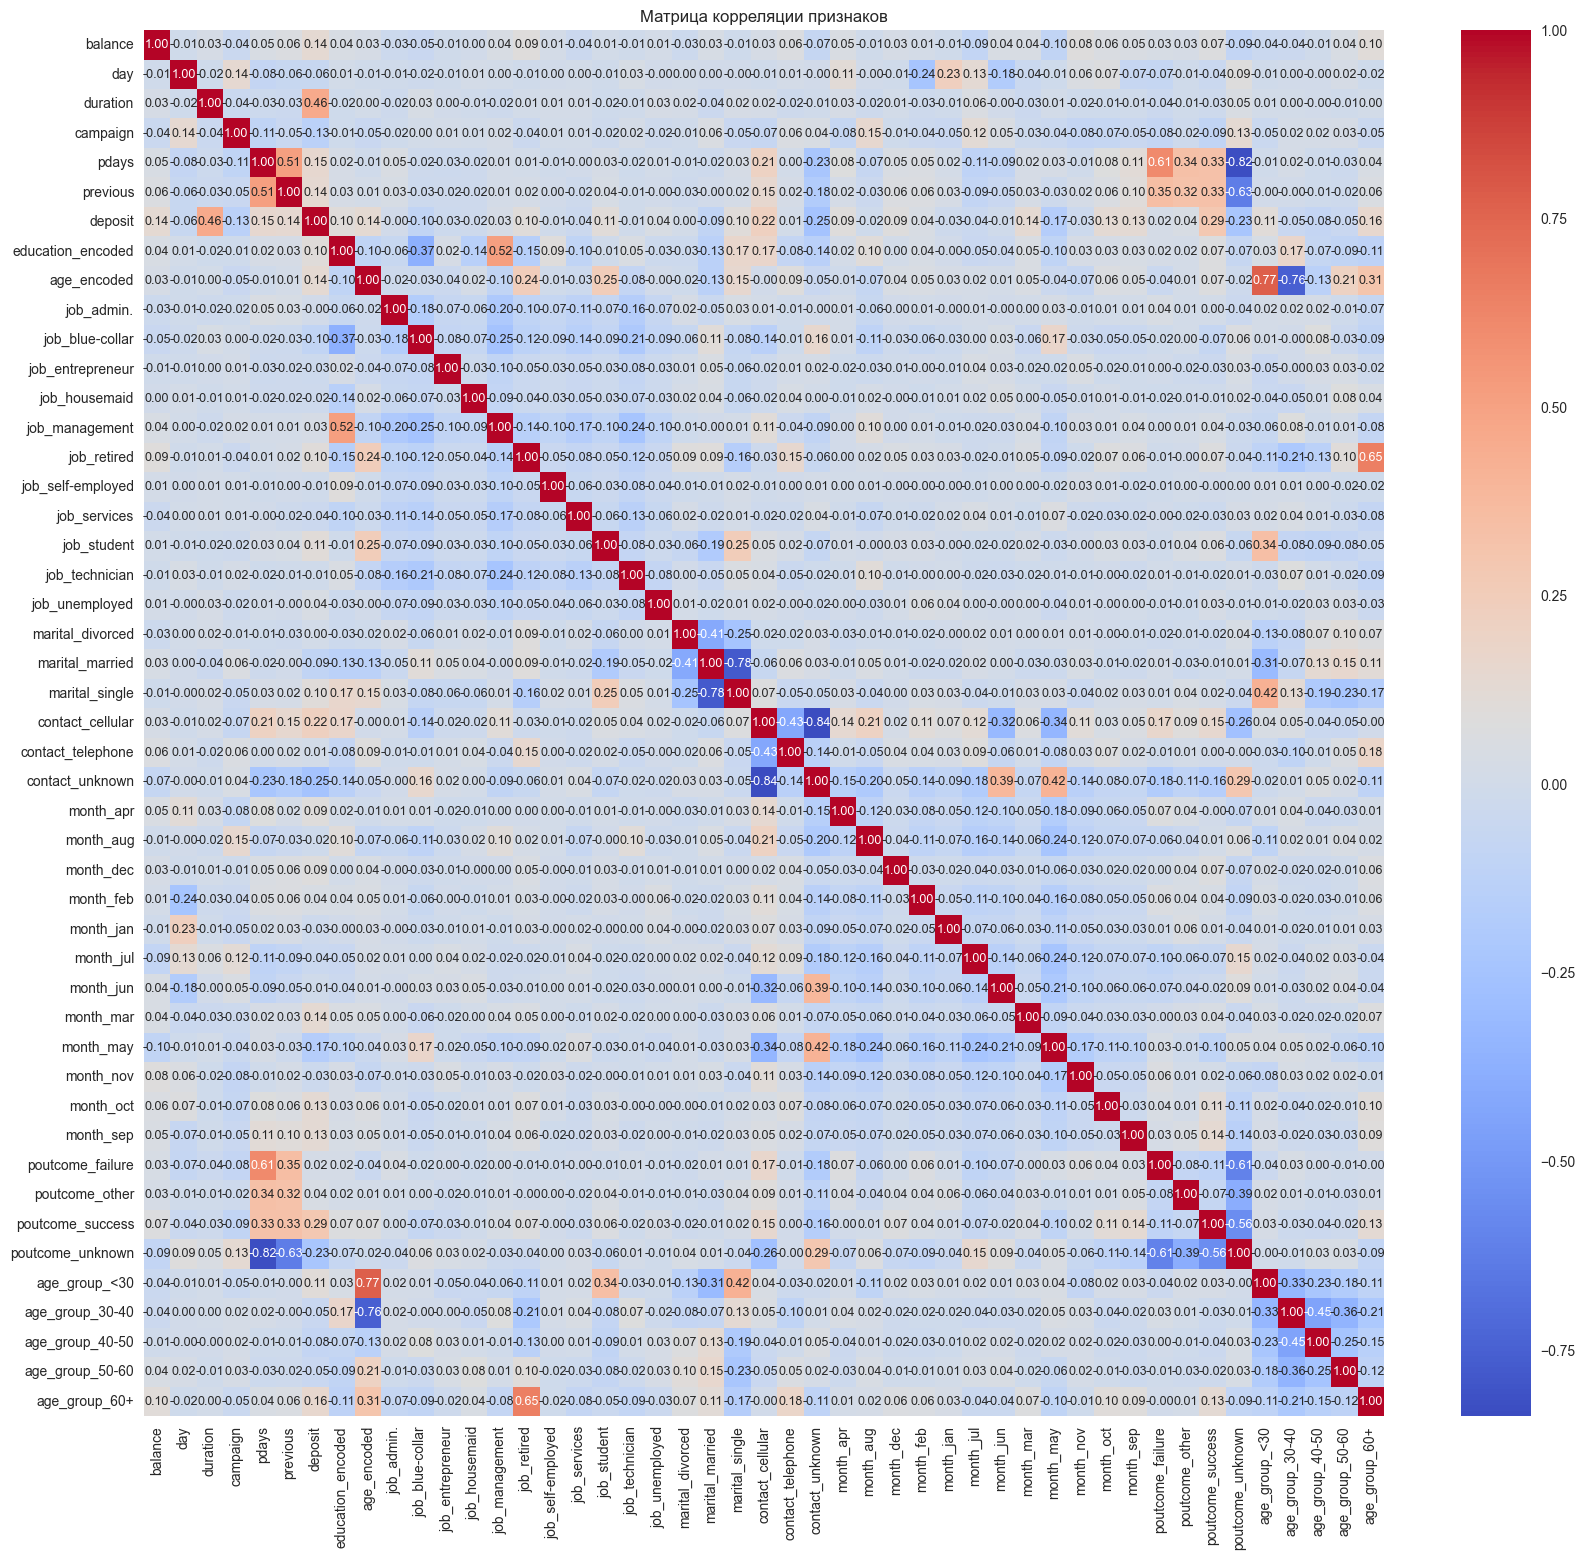

In [115]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
cor_matrix = df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 9})
plt.title('Матрица корреляции признаков')
plt.show()

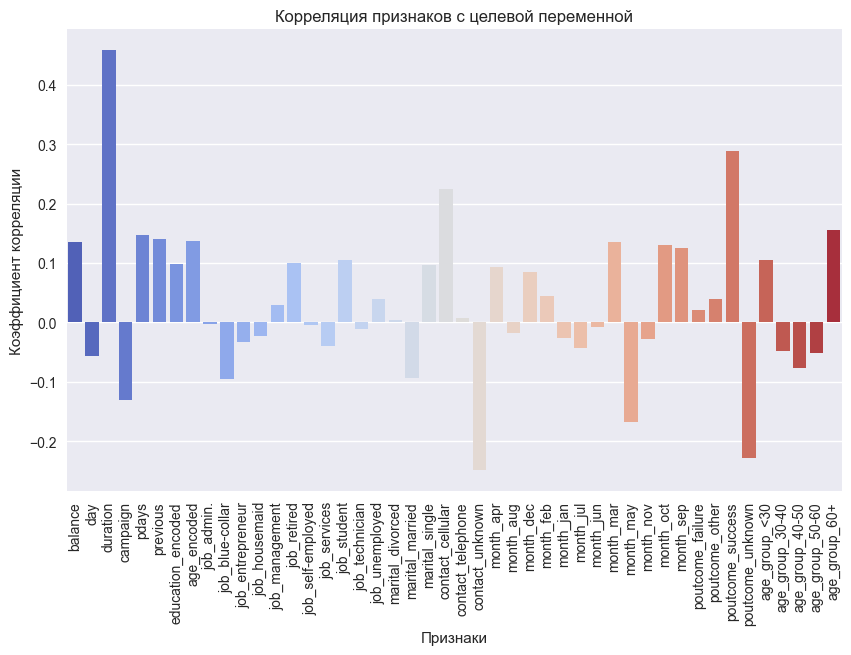

In [116]:
# Вычисление коэффициентов корреляции между признаками и целевой переменной
correlation = df.corr()['deposit'].drop('deposit')

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции')
plt.title('Корреляция признаков с целевой переменной')
plt.show()


Проанализировав матрицу корреляций, можно сделать вывод, что нет сильной мультиколлинеарности между признаками. Однако есть несколько признаков, которые сильно коррелируют с целевой переменной (открытием депозита):

Продолжительность контакта в секундах (duration) - чем больше длится контакт с клиентом, тем больше вероятность, что он откроет депозит.
Успех результата прошлой маркетинговой кампании (poutcome_success) - если предыдущая кампания была успешной, это может положительно повлиять на открытие депозита.
Контакт с клиентом по сотовому телефону (contact_cellular) - связь с клиентами через сотовый телефон может быть более эффективной, что способствует открытию депозита.

### Задания 7 и 8

In [117]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер тестовой выборки X_test=(3335, 46), y_test=3335


In [118]:
# рассчитайте необходимые показатели
mean_test = y_test.mean()
print('Среднее значение целевой переменной на тестовой выборке:', round(mean_test, 2))

Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [120]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices].tolist()
print(selected_features)


['balance', 'duration', 'campaign', 'pdays', 'previous', 'age_encoded', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'age_group_60+']


### Задание 10

In [122]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

In [123]:
# среднее арифметическое для первого предиктора (первого столбца) из тестовой выборки
mean_first_predictor = X_test_scal.iloc[:, 0].mean()
print(round(mean_first_predictor, 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [124]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scal, y_train)
y_test_pred = log_reg.predict(X_test_scal)
y_train_pred = log_reg.predict(X_train_scal)
print(f'Test: {metrics.classification_report(y_test, y_test_pred)}')
print(f'Train: {metrics.classification_report(y_train, y_train_pred)}')

 Test:               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1790
           1       0.82      0.77      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

 Train:               precision    recall  f1-score   support

           0       0.83      0.87      0.85      3634
           1       0.84      0.79      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.84      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770



### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth= 6
)
dt.fit(X_train_scal, y_train)
y_test_pred = dt.predict(X_test_scal)
y_train_pred = dt.predict(X_train_scal)
print(f'Test: {metrics.classification_report(y_test, y_test_pred)}')
print(f'Train: {metrics.classification_report(y_train, y_train_pred)}')

 Test:               precision    recall  f1-score   support

           0       0.80      0.83      0.81      1790
           1       0.80      0.75      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.79      0.79      3335
weighted avg       0.80      0.80      0.80      3335

 Train:               precision    recall  f1-score   support

           0       0.81      0.87      0.84      3634
           1       0.83      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770



### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7],
}
model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
grid_search.fit(X_train_scal, y_train)
print('Accuracy на тестовом наборе: {:.2f}'.format(grid_search.score(X_test_scal, y_test)))
y_test_pred = grid_search.predict(X_test_scal)
print('F1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

Accuracy на тестовом наборе: 0.80
F1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5, 
    random_state=42 
)
rf.fit(X_train_scal, y_train)
y_test_pred = rf.predict(X_test_scal)
y_train_pred = rf.predict(X_train_scal)
print(f'Test: {metrics.classification_report(y_test, y_test_pred)}')
print(f'Train: {metrics.classification_report(y_train, y_train_pred)}')

 Test:               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

 Train:               precision    recall  f1-score   support

           0       0.89      0.86      0.88      3634
           1       0.85      0.88      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770



### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    learning_rate=0.05,
    max_depth=5         
)
gb.fit(X_train_scal, y_train)
y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Test: {metrics.classification_report(y_test, y_test_pred)}')
print(f'Train: {metrics.classification_report(y_train, y_train_pred)}')

Test:               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Train:               precision    recall  f1-score   support

           0       0.93      0.91      0.92      3634
           1       0.90      0.92      0.91      3136

    accuracy                           0.92      6770
   macro avg       0.91      0.92      0.92      6770
weighted avg       0.92      0.92      0.92      6770



### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('lr', log_reg),
    ('dt',  dt),
    ('rf', rf)    
]
steg_model = StackingClassifier(
    estimators=estimators,
    final_estimator=gb)
steg_model.fit(X_train_scal, y_train)
y_train_pred = steg_model.predict(X_train_scal)
y_test_pred = steg_model.predict(X_test_scal)
print(f'Test: {metrics.classification_report(y_test, y_test_pred)}')
print(f'Train: {metrics.classification_report(y_train, y_train_pred)}')
print('F1_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))


Test:               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Train:               precision    recall  f1-score   support

           0       0.89      0.86      0.88      3634
           1       0.85      0.88      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

F1_score на тестовом наборе: 0.80


### Задание 5

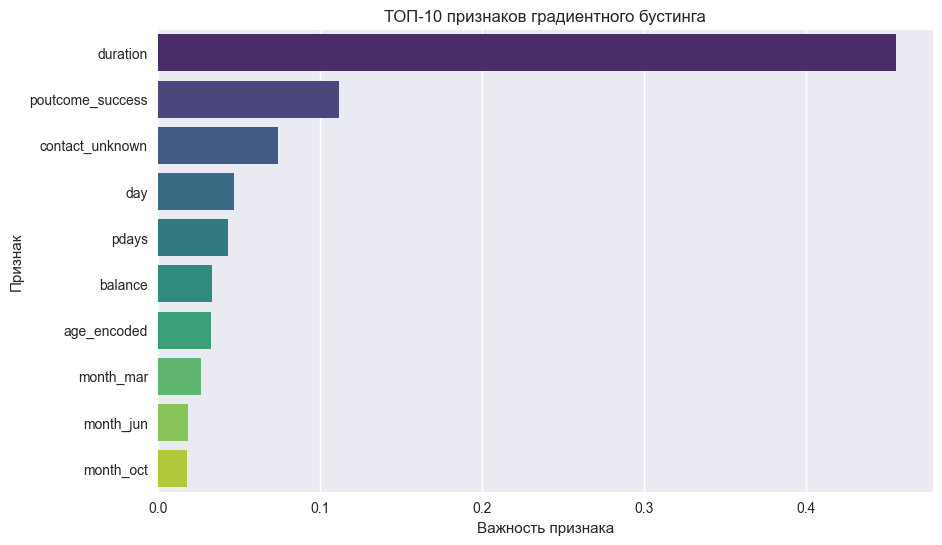

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feature_importance = pd.DataFrame({'feature': gb.feature_names_in_, 'importance': gb.feature_importances_})
top_features = feature_importance.nlargest(10, 'importance')

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('ТОП-10 признаков градиентного бустинга')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

### Задания 6,7,8

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
  max_depth = trial.suggest_int('max_depth', 10, 30, 1);
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = rf
  model.fit(X_train_scal, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scal))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)
print('Наилучшие значения гиперпараметров {}'.format(study.best_params))
print('F1_score на обучающем наборе: {:.2f}'.format(study.best_value))

[I 2023-07-26 15:52:16,566] A new study created in memory with name: RandomForestClassifier
[I 2023-07-26 15:52:16,903] Trial 0 finished with value: 0.8632104934415991 and parameters: {'n_estimators': 185, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8632104934415991.
[I 2023-07-26 15:52:17,220] Trial 1 finished with value: 0.8632104934415991 and parameters: {'n_estimators': 190, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8632104934415991.
[I 2023-07-26 15:52:17,533] Trial 2 finished with value: 0.8632104934415991 and parameters: {'n_estimators': 176, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8632104934415991.
[I 2023-07-26 15:52:17,849] Trial 3 finished with value: 0.8632104934415991 and parameters: {'n_estimators': 145, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8632104934415991.
[I 2023-07-26 15:52:18,164] Trial 4 finished with value: 0.8632104934415991 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 185, 'max_depth': 17, 'min_samples_leaf': 8}
f1_score на обучающем наборе: 0.86


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scal, y_train)
y_train_pred = model.predict(X_train_scal)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scal, y_test)))
y_test_pred = model.predict(X_test_scal)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.83


In [126]:
# результатов оценки различных метрик
metrics_dict = {
    'Model': ['Logistic Regression', 'Decision Tree (depth=6)', 'Decision Tree (optimal)', 
              'Random Forest (optimal)', 'Gradient Boosting', 'Stacking'],
    'Accuracy': [0.81, 0.80, 0.80, 0.84, 0.85, 0.83],
    'F1-score': [0.79, 0.77, 0.79, 0.83, 0.84, 0.80]
}
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

                     Model  Accuracy  F1-score
0      Logistic Regression      0.81      0.79
1  Decision Tree (depth=6)      0.80      0.77
2  Decision Tree (optimal)      0.80      0.79
3  Random Forest (optimal)      0.84      0.83
4        Gradient Boosting      0.85      0.84
5                 Stacking      0.83      0.80


### ВЫВОДЫ

Исходя из проделанной работы, можно сделать выводы, что лояльные клиенты, которые уже открывали депозиты в предыдущих кампаниях, представляют собой важную группу, которую стоит учитывать в новых маркетинговых кампаниях. Удержание лояльных клиентов и использование успешных стратегий из предыдущих кампаний могут значительно повысить эффективность новых маркетинговых усилий. Важно также решить вопрос с неизвестными типами контакта и результатами предыдущих кампаний, чтобы обеспечить более точное планирование будущих маркетинговых действий.

В ходе исследования были выделены три наиболее важных признака, которые оказывают наибольшее влияние на решение клиента открыть депозит:

* Продолжительность контакта (duration). Длительность контакта является важным фактором, зависящим от умения сотрудников банка проводить эффективные коммуникации с клиентами.
* Результат прошлой маркетинговой кампании (poutcome_success): Клиенты, которые успешно участвовали в предыдущей кампании и согласились на предложение, склонны к положительным решениям и в новых кампаниях. Это подчеркивает важность удержания лояльных клиентов и использования успешных методов из прошлых кампаний.
* Тип контакта с клиентом (contact_unknown): Когда тип контакта неизвестен, это может негативно повлиять на результаты кампании. Важно более тщательно подходить к выбору контактных методов и следить за тем, чтобы информация была доступна и понятна клиентам.


Общий вывод:

Наилучшее качество модели на тестовой выборке достигается при использовании случайного леса с подобранными оптимальными гиперпараметрами, где accuracy составляет 0.84, а F1-score - 0.83.
Модель градиентного бустинга также показывает хорошие результаты с accuracy 0.85 и F1-score 0.84.
Стекинг логистической регрессии, решающих деревьев и случайного леса с градиентным бустингом дает неплохие результаты, но немного уступает остальным моделям.